## Background

- Deep neural net

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy.special import expit

In [2]:
def load_data():
    with open('train-labels-idx1-ubyte', 'rb') as labels:
        magic, n = struct.unpack('>II', labels.read(8)) ##reading 8 bytes, first 2 lines
        train_labels = np.fromfile(labels, dtype=np.uint8)
        print(train_labels)
    with open('train-images-idx3-ubyte', 'rb') as images:
        magic, num, nrows, ncols = struct.unpack(">IIII", images.read(16)) ##reading 16 bytes, first 4 lines
        train_images = np.fromfile(images, dtype=np.uint8).reshape(num, 784) ##reshaping image as 784 row vecotr (28x28 px)
        print(train_images)
    with open('t10k-labels-idx1-ubyte', 'rb') as labels:
        magic, n = struct.unpack('>II', labels.read(8)) ##reading 8 bytes, first 2 lines
        test_labels = np.fromfile(labels, dtype=np.uint8)
    with open('t10k-images-idx3-ubyte', 'rb') as images:
        magic, num, nrows, ncols = struct.unpack(">IIII", images.read(16)) ##reading 16 bytes, first 4 lines
        test_images = np.fromfile(images, dtype=np.uint8).reshape(num, 784) ##reshaping image as 784 row vecotr (28x28 px)
    return train_images, train_labels, test_images, test_labels   

In [3]:
def visualize_data(img_array, label_array):
    fig, ax = plt.subplots(nrows=8, ncols=8, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(64):
        img = img_array[label_array == 9][i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    plt.show()

[5 0 4 ... 5 6 8]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


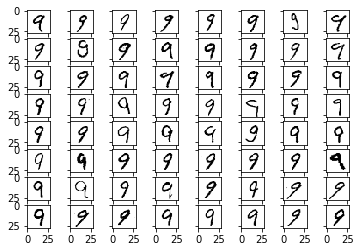

In [4]:
train_x, train_y, test_x, test_y = load_data()
visualize_data(train_x, train_y)

In [5]:
#vertical col vector is the one hot encoded category essentially with each col being each label
def enc_one_hot(y, num_labels=10):
    one_hot = np.zeros((num_labels, y.shape[0]))
    for i, val in enumerate(y):
        one_hot[val,i] = 1.0
    return one_hot
y = np.array([4, 5, 9, 0])
z = enc_one_hot(y)
print(y)
print(z)

[4 5 9 0]
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]


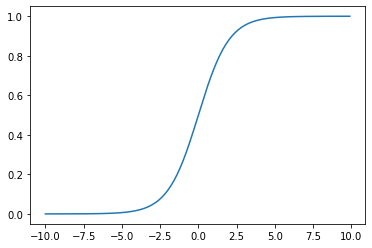

In [6]:
def sigmoid(z):
    #return(1 / (1 + np.exp(-z)))
    return expit(z)

def sigmoid_gradient(z):
    s = sigmoid(z)
    return s * (1 - s)

def visualize_sigmoid():
    x = np.arange(-10, 10, 0.1)
    y = sigmoid(x)
    fig, ax = plt.subplots()
    ax.plot(x,y)
    plt.show()
visualize_sigmoid()

In [7]:
def calc_cost(y_enc, outpt):
    t1 = -y_enc * np.log(outpt)
    t2 = (1 - y_enc)*np.log(1-outpt)
    cost = np.sum(t1 - t2)
    return cost

In [8]:
def add_bias_unit(X, where):
    # where is just row or column
    if where == 'column':
        X_new = np.ones((X.shape[0], X.shape[1] + 1))
        X_new[:, 1:] = X
    elif where == 'row':
        X_new = np.ones((X.shape[0] + 1, X.shape[1]))
        X_new[1:, :] = X
    return X_new

In [9]:
def init_weights(n_features, n_hidden, n_output):
    w1 = np.random.uniform(-1.0, 1.0, size=n_hidden*(n_features+1))
    w1 = w1.reshape(n_hidden, n_features+1)
    w2 = np.random.uniform(-1.0, 1.0, size=n_hidden*(n_hidden+1))
    w2 = w2.reshape(n_hidden, n_hidden+1)
    w3 = np.random.uniform(-1.0, 1.0, size=n_output*(n_hidden+1))
    w3 = w3.reshape(n_output, n_hidden+1)
    return w1, w2, w3

In [10]:
def feed_forward(x, w1, w2, w3):
    # add bias unit to the input
    # column within the row is just a byte of data
    # so we need to add a column vector of ones
    a1 = add_bias_unit(x, where='column')
    
    z2 = w1.dot(a1.T)
    a2 = sigmoid(z2)
    # since we transposed we have to add bias units as a row
    a2 = add_bias_unit(a2, where='row')
    
    z3 = w2.dot(a2)
    a3 = sigmoid(z3)
    a3 = add_bias_unit(a3, where='row')
    
    z4 = w3.dot(a3)
    a4 = sigmoid(z4)

    return a1, z2, a2, z3, a3, z4, a4

def predict(x, w1, w2, w3):
    a1, z2, a2, z3, a3, z4, a4 = feed_forward(x, w1, w2, w3)
    y_pred = np.argmax(a4, axis=0)
    return y_pred

def calc_grad(a1, a2, a3, a4, z2, z3, z4, y_enc, w1, w2, w3):
    delta4 = a4 - y_enc
    z3 = add_bias_unit(z3, where='row')
    delta3 = w3.T.dot(delta4)*sigmoid_gradient(z3)
    delta3 = delta3[1:, :]
    z2 = add_bias_unit(z2, where='row')
    delta2 = w2.T.dot(delta3)*sigmoid_gradient(z2)
    delta2 = delta2[1:,:]

    grad1 = delta2.dot(a1)
    grad2 = delta3.dot(a2.T)
    grad3 = delta4.dot(a3.T)

    return grad1, grad2, grad3

[5 0 4 ... 5 6 8]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
epoch # 0
epoch # 1
epoch # 2
epoch # 3
epoch # 4
epoch # 5
epoch # 6
epoch # 7
epoch # 8
epoch # 9
epoch # 10
epoch # 11
epoch # 12
epoch # 13
epoch # 14
epoch # 15
epoch # 16
epoch # 17
epoch # 18
epoch # 19
epoch # 20
epoch # 21
epoch # 22
epoch # 23
epoch # 24
epoch # 25
epoch # 26
epoch # 27
epoch # 28
epoch # 29
epoch # 30
epoch # 31
epoch # 32
epoch # 33
epoch # 34
epoch # 35
epoch # 36
epoch # 37
epoch # 38
epoch # 39
epoch # 40
epoch # 41
epoch # 42
epoch # 43
epoch # 44
epoch # 45
epoch # 46
epoch # 47
epoch # 48
epoch # 49
epoch # 50
epoch # 51
epoch # 52
epoch # 53
epoch # 54
epoch # 55
epoch # 56
epoch # 57
epoch # 58
epoch # 59
epoch # 60
epoch # 61
epoch # 62
epoch # 63
epoch # 64
epoch # 65
epoch # 66
epoch # 67
epoch # 68
epoch # 69
epoch # 70
epoch # 71
epoch # 72
epoch # 73
epoch # 74
epoch # 75
epoch # 76
epoch # 77
epoch # 78
epo

epoch # 681
epoch # 682
epoch # 683
epoch # 684
epoch # 685
epoch # 686
epoch # 687
epoch # 688
epoch # 689
epoch # 690
epoch # 691
epoch # 692
epoch # 693
epoch # 694
epoch # 695
epoch # 696
epoch # 697
epoch # 698
epoch # 699
epoch # 700
epoch # 701
epoch # 702
epoch # 703
epoch # 704
epoch # 705
epoch # 706
epoch # 707
epoch # 708
epoch # 709
epoch # 710
epoch # 711
epoch # 712
epoch # 713
epoch # 714
epoch # 715
epoch # 716
epoch # 717
epoch # 718
epoch # 719
epoch # 720
epoch # 721
epoch # 722
epoch # 723
epoch # 724
epoch # 725
epoch # 726
epoch # 727
epoch # 728
epoch # 729
epoch # 730
epoch # 731
epoch # 732
epoch # 733
epoch # 734
epoch # 735
epoch # 736
epoch # 737
epoch # 738
epoch # 739
epoch # 740
epoch # 741
epoch # 742
epoch # 743
epoch # 744
epoch # 745
epoch # 746
epoch # 747
epoch # 748
epoch # 749
epoch # 750
epoch # 751
epoch # 752
epoch # 753
epoch # 754
epoch # 755
epoch # 756
epoch # 757
epoch # 758
epoch # 759
epoch # 760
epoch # 761
epoch # 762
epoch # 763
epoc

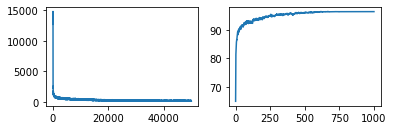

In [11]:
def runModel(X, y, X_t, y_t):
    X_copy, y_copy = X.copy(), y.copy()
    y_enc = enc_one_hot(y)
    epochs = 1000
    batch = 50

    w1, w2, w3 = init_weights(784, 75, 10)

    alpha = 0.001
    eta = 0.001
    dec = 0.00001
    delta_w1_prev = np.zeros(w1.shape)
    delta_w2_prev = np.zeros(w2.shape)
    delta_w3_prev = np.zeros(w3.shape)
    total_cost = []
    pred_acc = np.zeros(epochs)

    for i in range(epochs):

        shuffle = np.random.permutation(y_copy.shape[0])
        X_copy, y_enc = X_copy[shuffle], y_enc[:, shuffle]
        eta /= (1 + dec*i)

        mini = np.array_split(range(y_copy.shape[0]), batch)

        for step in mini:
            # feed forward the model
            a1, z2, a2, z3, a3, z4, a4 = feed_forward(X_copy[step], w1, w2, w3)
            cost = calc_cost(y_enc[:,step], a4)

            total_cost.append(cost)
            # back propagate
            grad1, grad2, grad3 = calc_grad(a1, a2, a3, a4, z2, z3, z4, y_enc[:,step],
                                            w1, w2, w3)
            delta_w1, delta_w2, delta_w3 = eta * grad1, eta * grad2, eta * grad3

            w1 -= delta_w1 + alpha * delta_w1_prev
            w2 -= delta_w2 + alpha * delta_w2_prev
            w3 -= delta_w3 + alpha * delta_w3_prev

            delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3_prev

        y_pred = predict(X_t, w1, w2, w3)
        pred_acc[i] = 100*np.sum(y_t == y_pred, axis=0) / X_t.shape[0]
        print('epoch #', i)
    return total_cost, pred_acc, y_pred, w1, w2, w3

train_x, train_y, test_x, test_y = load_data()

cost, acc, y_pred, w1, w2, w3 = runModel(train_x, train_y, test_x, test_y)

x_a = [i for i in range(acc.shape[0])]
x_c = [i for i in range(len(cost))]
print('final prediction accuracy is: ', acc[9])
plt.subplot(221)
plt.plot(x_c, cost)
plt.subplot(222)
plt.plot(x_a, acc)
plt.show()


In [12]:
print('final prediction accuracy is: ', acc[999])

final prediction accuracy is:  96.37


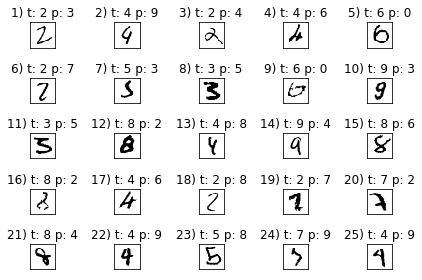

In [13]:
misclassified_img = test_x[test_y != y_pred][:25]
correct_label = test_y[test_y != y_pred][:25]
misclassified_label = y_pred[test_y != y_pred][:25]

fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = misclassified_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_label[i], misclassified_label[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()



array([8])

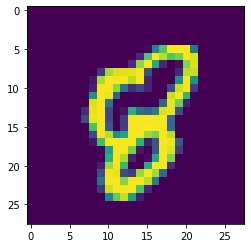

In [47]:
X_copy, y_copy = test_x.copy(), test_y.copy()
shuffle = np.random.permutation(y_copy.shape[0])
X_copy = X_copy[shuffle]
#print(X_copy[0])
plt.imshow(X_copy[0].reshape(28, 28))
a1, z2, a2, z3, a3, z4, a4 = feed_forward(X_copy[0].reshape(1, 784), w1, w2, w3)
y_pred = np.argmax(a4, axis=0)
y_pred

In [52]:
!pip install ipycanvas

In [55]:
from ipycanvas import Canvas

canvas = Canvas(width=200, height=200)

canvas.fill_rect(25, 25, 100, 100)
canvas.clear_rect(45, 45, 60, 60)
canvas.stroke_rect(50, 50, 50, 50)

canvas

Canvas(height=200, width=200)

In [68]:
from tkinter import *
from tkinter import ttk, colorchooser, filedialog
import PIL
from PIL import ImageGrab


class main:
    def __init__(self,master):
        self.master = master
        self.color_fg = 'black'
        self.color_bg = 'white'
        self.old_x = None
        self.old_y = None
        self.penwidth = 5
        self.drawWidgets()
        self.c.bind('<B1-Motion>',self.paint)
        self.c.bind('<ButtonRelease-1>',self.reset)

    def paint(self,e):
        if self.old_x and self.old_y:
            self.c.create_line(self.old_x,self.old_y,e.x,e.y,width=self.penwidth,fill=self.color_fg,capstyle=ROUND,smooth=True)

        self.old_x = e.x
        self.old_y = e.y

    def reset(self,e):
        self.old_x = None
        self.old_y = None      

    def changeW(self,e):
        self.penwidth = e

    def save(self):
        file = filedialog.asksaveasfilename(filetypes=[('Portable Network Graphics','*.png')])
        if file:
            x = self.master.winfo_rootx() + self.c.winfo_x()
            y = self.master.winfo_rooty() + self.c.winfo_y()
            x1 = x + self.c.winfo_width()
            y1 = y + self.c.winfo_height()

            PIL.ImageGrab.grab().crop((x,y,x1,y1)).save(file + '.png')
            
           

    def clear(self):
        self.c.delete(ALL)

    def change_fg(self):
        self.color_fg=colorchooser.askcolor(color=self.color_fg)[1]

    def change_bg(self):
        self.color_bg=colorchooser.askcolor(color=self.color_bg)[1]
        self.c['bg'] = self.color_bg

    def drawWidgets(self):
        self.controls = Frame(self.master,padx = 5,pady = 5)
        Label(self.controls, text='Pen Width: ',font=('',15)).grid(row=0,column=0)
        self.slider = ttk.Scale(self.controls,from_= 5, to = 100, command=self.changeW,orient=HORIZONTAL)
        self.slider.set(self.penwidth)
        self.slider.grid(row=0,column=1,ipadx=30)
        self.controls.pack()
        
        self.c = Canvas(self.master,width=500,height=400,bg=self.color_bg,)
        self.c.pack(fill=BOTH,expand=True)

        menu = Menu(self.master)
        self.master.config(menu=menu)
        filemenu = Menu(menu)
        menu.add_cascade(label='File..',menu=filemenu)
        filemenu.add_command(label='Export..',command=self.save)
        colormenu = Menu(menu)
        menu.add_cascade(label='Colors',menu=colormenu)
        colormenu.add_command(label='Brush Color',command=self.change_fg)
        colormenu.add_command(label='Background Color',command=self.change_bg)
        optionmenu = Menu(menu)
        menu.add_cascade(label='Options',menu=optionmenu)
        optionmenu.add_command(label='Clear Canvas',command=self.clear)
        optionmenu.add_command(label='Exit',command=self.master.destroy) 
        
        

if __name__ == '__main__':
    root = Tk()
    main(root)
    root.title('DrawingApp')
    root.mainloop()